# Assignment 2: Market liquidity in the age of COVID

In this assignment, we will study the impact of COVID-19 on liquidity provision on Canadian markets. Which Canadian brokers provided liquidity in the highly-volatile weeks of March 2020, helping the market from crashing further? Which Canadian brokers scrambled for the exit, and in which asset classes? 

To understand the answer to these questions, we zoom in on Toronto Stock Exchange trades between March 9 and March 20, 2020 for six large ETFs. The ETFs selected track various asset classes, from equity indices (TSX 60, S&P 500, and Nasdaq 100), bond prices, gold prices, and real-estate prices (REITS).

**List of ETFs in the sample**

1. XIU.TO: IShares TSX 60 
2. ZSP.TO: BMO S&P 500
3. ZAG.TO: BMO Aggregate Bond
4. XGD.TO: IShares S&P TSX Global Gold
5. XQQ.TO: IShares Nasdaq 100
6. ZRE.TO: BMO Reits

The dataset is available at:  
`https://github.com/mgt412/course_notebooks/blob/master/Datasets/A2_TradeDataset.csv?raw=true`  

**Dataset variable description**

| # 	| Column  | Description   	|
|---	|---	|---	|
|  1 	|  `#RIC`	| ETF ticker   	|
|  2 	|  `Time` | Trade time with nanosecond timestamp  	|
|  3 	|  `Price` 	|  Trade price in CAD  	|
|  4 	|  `Volume` 	| Trade quantity in units  	|
|  5 	|  `Buyer`	|  Identity of buyer in the trade 	|
|  6 	|  `Seller` 	|  Identity of seller in the trade  	|
|  7 	|   `Midpoint`	|  Average of best bid and ask prices at the time of trade  |
|  8 	|   `Midpoint_T+20`	|  Average of best bid and ask prices, 20 seconds after the trade  |

## Preliminaries (5p)

1. Load the dataset from the given *url* address. Display the first 5 entries.

Familiarize yourself with the data.

2. How many trades are in the sample? 
3. How many brokers are in the sample? Count the number of trades for each broker, and display the top 10 brokers sorted descendingly (i.e., display the broker with most trades first)

In [1]:
import pandas as pd
url='https://github.com/mgt412/course_notebooks/blob/master/Datasets/A2_TradeDataset.csv?raw=true'
data=pd.read_csv(url,index_col=0)
data.head()

,#RIC,Time,Price,Volume,Buyer,Seller,Midpoint,Midpoint_T+20
0,XGD.TO,2020-03-09 09:50:00.695791862,16.48,200.0,TD Securities Inc.,Anonymous,16.490,16.5875
1,XGD.TO,2020-03-09 09:50:07.892297432,16.47,800.0,Instinet Canada Ltd.,TD Securities Inc.,16.475,16.5875
2,XGD.TO,2020-03-09 09:50:08.784362702,16.46,200.0,CIBC World Markets Inc.,Anonymous,16.475,16.5875
3,XGD.TO,2020-03-09 09:50:09.907234027,16.46,100.0,Instinet Canada Ltd.,BMO Nesbitt Burns Inc.,16.465,16.5875
4,XGD.TO,2020-03-09 09:50:16.671435731,16.46,200.0,Instinet Canada Ltd.,CIBC World Markets Inc.,16.465,16.9600


In [2]:
no_trades=data.count()['#RIC']
print("Number of trades:", no_trades)

Number of trades: 141670


In [3]:
# Sort the top 10 brokers
buyers=data.groupby('Buyer').count()['#RIC'].sort_values(ascending=False)
sellers=data.groupby('Seller').count()['#RIC'].sort_values(ascending=False)

buyers=buyers.reset_index()
buyers=buyers.rename(columns={'Buyer':'Broker'})

sellers=sellers.reset_index()
sellers=sellers.rename(columns={'Seller':'Broker'})

brokers=buyers.merge(sellers,on='Broker')
brokers['Trades']=brokers['#RIC_x']+brokers['#RIC_y']
del brokers['#RIC_x']
del brokers['#RIC_y']
brokers=brokers.sort_values(by='Trades',ascending=False).reset_index(drop=True)
brokers.head(10)

,Broker,Trades
0,CIBC World Markets Inc.,137378
1,Anonymous,50025
2,TD Securities Inc.,17646
3,BMO Nesbitt Burns Inc.,17227
4,National Bank Financial Inc.,16900
5,RBC Capital Markets,13293
6,Questrade Inc.,5061
7,Instinet Canada Ltd.,4806
8,Morgan Stanley Canada Ltd.,4264
9,Merrill Lynch Canada Inc.,3753


## Signing trades: The Lee-Ready algorithm (25p)

Any trade on the exchange has two parties: A buyer and a seller. However, how can we know who *initiated* the trade? If the trade was initiated by a buyer, this could mean good news for the stock or ETF. Otherwise, if it was a seller who triggered the trade, this could imply bad news for the future price.

We refer to identifiying the trade initiator as *"signing the trade"*.   
For any trade on the exchange, we can distinguish between a **market-maker** and a **market-taker**.

<img src="https://github.com/mgt412/course_notebooks/raw/master/Figures/makertaker.jpg" width="700px">

The **market-maker** posts two "quotes": a price at which she is willing to buy the stock (\$20) and a price at which she is willing to sell the stock (\$25). Note that the market-maker will gain \$5 if she buys the stock and then sells it immediately.

However, the market-maker does not initiate a trade. She passively offers others the opportunity (option) to trade with her immediately at the stated prices, therefore providing *liquidity* to the market.

It is a **marker-taker** who arrives at the market, observes the quotes, and decides to take action. In the figure above, the market-taker initiates a trade by selling the asset for \$20 (and the market-maker has to buy it). We would sign this trade as a `SELL`. Also, note that for a `SELL` trade, the actual trade price (\$20) is lower than the mid-point of \$22.5.

Note that this action may convey information  about the stock. The **market-taker** saw the bid/ask prices and decided that selling at \$20 is a good idea. That is, he believes the price might go down even more! Since the **market-taker** always acts after the **market-maker** does, he might actually have better information.

**Lee-Ready algorithm**

To sign the trades, we use the Lee-Ready algorithm:
1. If the trade price is higher (lower) than the midpoint, then the trade is classified as a `BUY` (`SELL`)
2. If the trade price is equal to the midpoint:  
    a) If the trade price is higher than the price of the previous trade, classify as `BUY` (uptick) 
    b) If the trade price is lower than the price of the previous trade, classify as `SELL` (downtick)
3. If the trade price is equal to the midpoint and equal to the previous trades' price:  
    a) If the last price change was an uptick (price moving higher), classify as `BUY`  
    b) If the last price change was an downtick (price moving lower), classify as `SELL` 

**(Task)** Implement the Lee-Ready algorithm on our dataset, and create a column `TradeSign` which takes the value 1 for buys and -1 for sells. 

In [4]:
def lee_ready(dataset):
    # Lee-Ready (1991) algorithm
    dataset.loc[dataset['Price']>dataset['Midpoint'],'TradeSign']=1 # classify as a buy (directly)
    dataset.loc[dataset['Price']<dataset['Midpoint'],'TradeSign']=-1 # classify as a sell (directly)

    # tick test 
    dataset.loc[dataset['Price']>dataset['Price'].shift(1),'Tick']='Uptick'
    dataset.loc[dataset['Price']<dataset['Price'].shift(1),'Tick']='Downtick'
    dataset['Tick']=dataset['Tick'].fillna(method='ffill')
    dataset.loc[(dataset['Price']==dataset['Midpoint']) &
                 (dataset['Tick']=='Uptick'),'TradeSign']=1
    dataset.loc[(dataset['Price']==dataset['Midpoint']) &
                 (dataset['Tick']=='Downtick'),'TradeSign']=-1
    del dataset['Tick']
    return dataset

In [5]:
data=lee_ready(data)
data.head()

,#RIC,Time,Price,Volume,Buyer,Seller,Midpoint,Midpoint_T+20,TradeSign
0,XGD.TO,2020-03-09 09:50:00.695791862,16.48,200.0,TD Securities Inc.,Anonymous,16.490,16.5875,-1.0
1,XGD.TO,2020-03-09 09:50:07.892297432,16.47,800.0,Instinet Canada Ltd.,TD Securities Inc.,16.475,16.5875,-1.0
2,XGD.TO,2020-03-09 09:50:08.784362702,16.46,200.0,CIBC World Markets Inc.,Anonymous,16.475,16.5875,-1.0
3,XGD.TO,2020-03-09 09:50:09.907234027,16.46,100.0,Instinet Canada Ltd.,BMO Nesbitt Burns Inc.,16.465,16.5875,-1.0
4,XGD.TO,2020-03-09 09:50:16.671435731,16.46,200.0,Instinet Canada Ltd.,CIBC World Markets Inc.,16.465,16.9600,-1.0


## Decompose the effective spread (10p)

A good measure for transaction costs in a given trade is the **effective spread,** the distance between the transaction price $p$ and the midpoint $m$, scaled by the midpoint:
$$\text{Effective spread}=\frac{\text{Direction} \times \left(p-m\right)}{m}.$$

If the midpoint is a good proxy for the fair value of a stock, then the effective spread shows how far the transaction price is from this fair value.

Typically after a trade, prices move in the direction of the trade: higher after a buyer-initiated trade and lower after a seller-initiated trade. To measure this, we can decompose the effective spread by looking at the midpoint value shortly after the trade (i.e., 20 seconds).

$$\text{Effective spread}=\underbrace{\frac{\text{Direction} \times \left(p-m_{t+\Delta}\right)}{m}}_{\text{Realized spread}}+\underbrace{\frac{\text{Direction} \times \left(m_{t+\Delta}-m\right)}{m}}_{\text{Price impact}}.$$

If a market maker would want to revert her position 20 seconds after the original spread, she would obtain the *realized spread*, which is typically lower than the effective spread since prices moved against her. 

The *price impact* component of the spread is a measure of how much prices moved in favour of the market taker (e.g., increased from $m$ to $m_{t+\Delta}$ after a buy).

Therefore, the *price impact* is a measure of how much information a market taker has about where prices will go, and also a measure of how much market-makers can lose by providing quotes for potentially more informed traders to use.

**(Task)** Compute the effective spread, realized spread, and price impact for each trade in the dataset, as new columns. Express these measures in basis points (i.e., multiply the values by 10,000).

In [6]:
data['Effective spread']=10**4*data['TradeSign']*(data['Price']-data['Midpoint'])/data['Midpoint']
data['Realized spread']=10**4*data['TradeSign']*(data['Price']-data['Midpoint_T+20'])/data['Midpoint']
data['Price impact']=10**4*data['TradeSign']*(data['Midpoint_T+20']-data['Midpoint'])/data['Midpoint']
data.head()

,#RIC,Time,Price,Volume,Buyer,Seller,Midpoint,Midpoint_T+20,TradeSign,Effective spread,Realized spread,Price impact
0,XGD.TO,2020-03-09 09:50:00.695791862,16.48,200.0,TD Securities Inc.,Anonymous,16.490,16.5875,-1.0,6.064281,65.191025,-59.126743
1,XGD.TO,2020-03-09 09:50:07.892297432,16.47,800.0,Instinet Canada Ltd.,TD Securities Inc.,16.475,16.5875,-1.0,3.034901,71.320182,-68.285281
2,XGD.TO,2020-03-09 09:50:08.784362702,16.46,200.0,CIBC World Markets Inc.,Anonymous,16.475,16.5875,-1.0,9.104704,77.389985,-68.285281
3,XGD.TO,2020-03-09 09:50:09.907234027,16.46,100.0,Instinet Canada Ltd.,BMO Nesbitt Burns Inc.,16.465,16.5875,-1.0,3.036745,77.436988,-74.400243
4,XGD.TO,2020-03-09 09:50:16.671435731,16.46,200.0,Instinet Canada Ltd.,CIBC World Markets Inc.,16.465,16.9600,-1.0,3.036745,303.674461,-300.637716


## Plot the effective spread (15p)

1. Plot the daily average effective spread (equally weighted across all trades) for XIU.TO, ZSP.TO, and XQQ.TO.
2. To do so, first convert the 'Time' column to *native* times using `pd.to_datetime'.
3. Then, extract the *Day* of the trade as a separate column.

Interpret your results in the plot. Which ETF has, generally, a higher expected spread? When did illiquidity peak for each ETF?

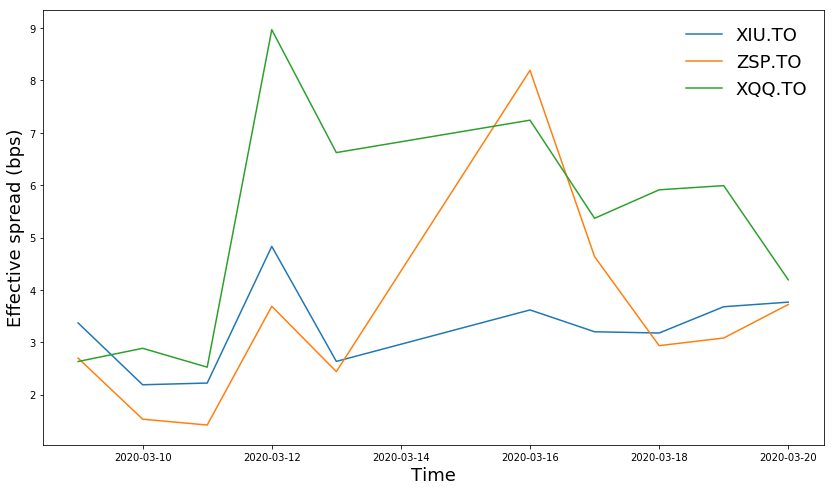

In [7]:
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# convert dates to native format
data['Time']=data['Time'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d %H:%M:%S.%f'))

# get the day
data['Day']=data['Time'].apply(lambda x: dt.datetime(x.year,x.month,x.day))

# average spread for day
data_day=data.groupby(['#RIC','Day']).mean()[['Effective spread','Realized spread','Price impact']].reset_index()

plt.figure(figsize=(14,8))
ric=['XIU.TO','ZSP.TO','XQQ.TO']
plt.plot(data_day[data_day['#RIC']==ric[0]]['Day'],data_day[data_day['#RIC']==ric[0]]['Effective spread'],label=ric[0])
plt.plot(data_day[data_day['#RIC']==ric[1]]['Day'],data_day[data_day['#RIC']==ric[1]]['Effective spread'],label=ric[1])
plt.plot(data_day[data_day['#RIC']==ric[2]]['Day'],data_day[data_day['#RIC']==ric[2]]['Effective spread'],label=ric[2])
plt.xlabel('Time',fontsize=18)
plt.ylabel('Effective spread (bps)',fontsize=18)
plt.legend(loc='best',frameon=False,fontsize=18)

## Who are the top market-makers? (25p)

Define a function that, given a particular ticker (e.g., `XIU.TO`), returns a `DataFrame` with:  
1. Total CAD volume, over the sample period, for each broker as a *market-maker*.  
2. Total CAD volume, over the sample period, for each broker as a *market-taker*.  
3. Total CAD volume, over the sample period, for each broker overall (both as maker and taker). 
4. The share of traded volume executed as market-maker (`MMShare`), out of total traded, for each broker.    

Answer the following questions, by displaying the corresponding `DataFrame` slice:

1. Who are the top 5 traders, by volume, in *XIU.TO*?
2. Who are the top 5 market-makers, by `MMShare`, in *XIU.TO* (who exceed \$10m of traded volume)?
3. Who are the top 5 market-makers, by `MMShare`, in *XIU.TO* (who exceed \$10m of traded volume)?
4. Interpret the behaviour of traders labeled *Anonymous*, in light of the discussion above.

Repeat the analysis for another ETF, at your choice. Discuss your findings.

In [8]:
import numpy as np


def makertaker_table(ric):
    
    data['VolumeCAD']=data['Volume']*data['Price'] # dollar value of a trade

    data['MarketMaker']=np.where(data['TradeSign']==1,data['Seller'],data['Buyer']) # market maker
    data['MarketTaker']=np.where(data['TradeSign']==1,data['Buyer'],data['Seller']) # market taker

    makers=data[data['#RIC']==ric].groupby(['MarketMaker']).agg({'VolumeCAD':'sum'}).sort_values(
        by='VolumeCAD',ascending=False).reset_index()
    makers=makers.rename(columns={'MarketMaker':'Broker','VolumeCAD':'MakerVolume'})

    takers=data[data['#RIC']==ric].groupby(['MarketTaker']).agg({'VolumeCAD':'sum'}).sort_values(
        by='VolumeCAD',ascending=False).reset_index()
    takers=takers.rename(columns={'MarketTaker':'Broker','VolumeCAD':'TakerVolume'})

    makertaker=makers.merge(takers,on='Broker',how='outer').fillna(0)
    makertaker['TotalVolume']=makertaker['MakerVolume']+makertaker['TakerVolume']
    makertaker['MakerRatio']=100*makertaker['MakerVolume']/makertaker['TotalVolume']
    
    return makertaker


ric='XIU.TO'
print("Top 5 traders in XIU:")
print(makertaker_table(ric).sort_values(
    'TotalVolume',ascending=False)[['Broker','TotalVolume']].reset_index(drop=True).head(5))

print("\n\nTop 5 market-takers in XIU, by taker-share (above 10 million)")
print(makertaker_table(ric)[makertaker_table(ric)['TotalVolume']>10**7].sort_values(
    'MakerRatio',ascending=True)[['Broker','MakerRatio']].reset_index(drop=True).head(5))

print("\n\nTop 5 market-makers in XIU, by maker-share (above 10 million)")
print(makertaker_table(ric)[makertaker_table(ric)['TotalVolume']>10**7].sort_values(
    'MakerRatio',ascending=False)[['Broker','MakerRatio']].reset_index(drop=True).head(5))

Top 5 traders in XIU:
                         Broker   TotalVolume
0      CIBC World Markets  Inc.  3.741998e+09
1                     Anonymous  6.636325e+08
2  National Bank Financial Inc.  4.717327e+08
3            TD Securities Inc.  4.191317e+08
4        BMO Nesbitt Burns Inc.  2.027374e+08


Top 5 market-takers in XIU, by taker-share (above 10 million)
                                 Broker  MakerRatio
0                  Instinet Canada Ltd.   19.818166
1  Société Générale Capital Canada Inc.   22.904405
2                    TD Securities Inc.   27.455510
3                             Anonymous   37.864684
4              CIBC World Markets  Inc.   48.473046


Top 5 market-makers in XIU, by maker-share (above 10 million)
                         Broker  MakerRatio
0        BMO Nesbitt Burns Inc.   84.039706
1           RBC Capital Markets   81.506519
2     Merrill Lynch Canada Inc.   81.266205
3    Morgan Stanley Canada Ltd.   79.334285
4  National Bank Financial Inc.   65.61905

## Who accumulated the top positions? (15p)

Define a function that, given a particular ticker (e.g., `XIU.TO`), returns a `DataFrame` with:  
1. Total CAD volume, over the sample period, for each broker as a *buyer*.  
2. Total CAD volume, over the sample period, for each broker as a *seller*.  
3. Total CAD volume, over the sample period, for each broker overall (both as buyer and seller). 
4. The imbalance position (buy-sell volume), as a percentage of total volume.  
5. The absolute size of the imbalance.

Answer the following questions, by displaying the corresponding `DataFrame` slice:

1. Who are the top 5 sellers, by volume, in *XIU.TO*?
2. Who are the top 5 sellers, by imbalance share, in *XIU.TO*? (who exceed \$10m of traded volume)
3. Who are the top 5 buyers, by volume, in *XIU.TO*?
4. Who are the top 5 buyers, by imbalance share, in *XIU.TO*? (who exceed \$10m of traded volume)

In [9]:
def buyerseller_table(ric):
    
    buyer_data=data[data['#RIC']==ric].groupby(['Buyer']).sum()['VolumeCAD'].reset_index()
    buyer_data=buyer_data.rename(columns={'Buyer':'Broker','VolumeCAD':'BuyVolume'})

    seller_data=data[data['#RIC']==ric].groupby(['Seller']).sum()['VolumeCAD'].reset_index()
    seller_data=seller_data.rename(columns={'Seller':'Broker','VolumeCAD':'SellVolume'})

    buyerseller=buyer_data.merge(seller_data,on='Broker',how='outer').fillna(0)
    buyerseller['NetPosition']=buyerseller['BuyVolume']-buyerseller['SellVolume']
    buyerseller['TotalPosition']=buyerseller['BuyVolume']+buyerseller['SellVolume']
    buyerseller['Imbalance']=100*buyerseller['NetPosition']/buyerseller['TotalPosition']
    buyerseller['AbsoluteImbalance']=buyerseller['Imbalance'].map(np.abs)

    return buyerseller


ric='XIU.TO'
print("Top 5 sellers in XIU:")
print(buyerseller_table(ric).sort_values(
    'SellVolume',ascending=False)[['Broker','SellVolume']].reset_index(drop=True).head(5))

print("\n\n Top 5 buyers in XIU:")
print(buyerseller_table(ric).sort_values(
    'BuyVolume',ascending=False)[['Broker','BuyVolume']].reset_index(drop=True).head(5))

print("\n\nTop 5 sellers in XIU, by imbalance (above 10 million)")
print(buyerseller_table(ric)[buyerseller_table(ric)['TotalPosition']>10**7].sort_values(
    'Imbalance',ascending=True)[['Broker','Imbalance']].reset_index(drop=True).head(5))

print("\n\nTop 5 buyers in XIU, by imbalance (above 10 million)")
print(buyerseller_table(ric)[buyerseller_table(ric)['TotalPosition']>10**7].sort_values(
    'Imbalance',ascending=False)[['Broker','Imbalance']].reset_index(drop=True).head(5))

Top 5 sellers in XIU:
                         Broker    SellVolume
0      CIBC World Markets  Inc.  1.884225e+09
1  National Bank Financial Inc.  3.090908e+08
2                     Anonymous  2.446761e+08
3            TD Securities Inc.  1.878518e+08
4        BMO Nesbitt Burns Inc.  1.328273e+08


 Top 5 buyers in XIU:
                         Broker     BuyVolume
0      CIBC World Markets  Inc.  1.857772e+09
1                     Anonymous  4.189564e+08
2            TD Securities Inc.  2.312799e+08
3  National Bank Financial Inc.  1.626419e+08
4     Merrill Lynch Canada Inc.  9.975015e+07


Top 5 sellers in XIU, by imbalance (above 10 million)
                         Broker  Imbalance
0  National Bank Financial Inc. -31.044906
1        BMO Nesbitt Burns Inc. -31.033834
2           RBC Capital Markets -25.587234
3          Instinet Canada Ltd. -13.946272
4      CIBC World Markets  Inc.  -0.706929


Top 5 buyers in XIU, by imbalance (above 10 million)
                                 

## Scatterplot: Imbalance and Market-Making share (10p)

Let's put together the results from the two previous tasks (the market maker behaviour and the buyer/seller behaviour).  
Generate a scatter plot (for the bond ETF `ZAG.TO`) with:
1. Imbalance (in %) on the x-axis
2. Market-maker share (in %) on the y-axis
Scale each data point by volume, expressed in CAD million.  


What do you notice? Is there a dominant behaviour of large traders?   
Do large sellers favour market or limit orders? What about large buyers?

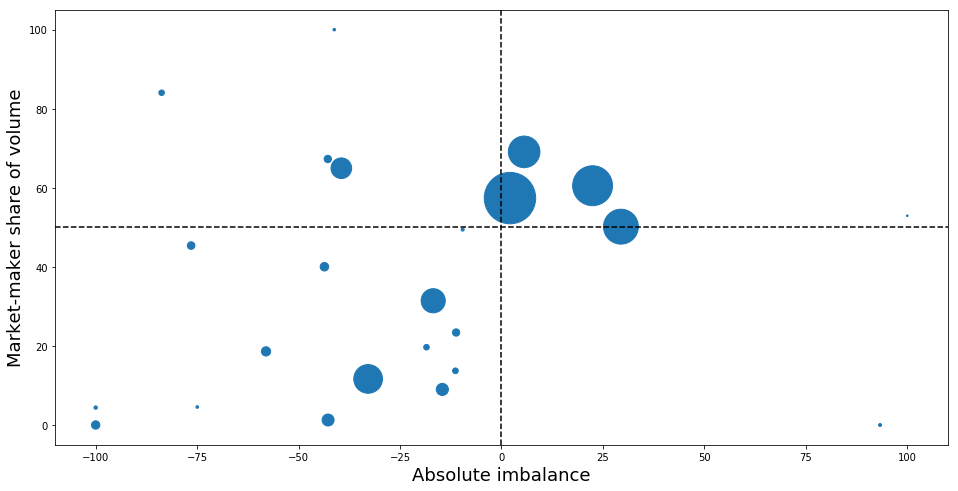

In [14]:
ric='ZAG.TO'
mt=makertaker_table(ric)
bs=buyerseller_table(ric)

scatter_data=mt[['Broker','MakerRatio','TotalVolume']].merge(
    bs[['Broker','AbsoluteImbalance','Imbalance']],on='Broker')

plt.figure(figsize=(16,8))
plt.scatter(scatter_data['Imbalance'],scatter_data['MakerRatio'],s=scatter_data['TotalVolume']/10**4)
plt.ylabel('Market-maker share of volume',fontsize=18)
plt.xlabel('Absolute imbalance',fontsize=18)
plt.axvline(0,ls='--',c='k')
plt.axhline(50,ls='--',c='k')